# به نام خدا 

# فاز یک


In [29]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.color import rgb2gray, rgb2hsv, rgb2lab
from skimage.transform import resize
from skimage.util import img_as_ubyte

In [30]:


# تنظیمات مسیر و پارامترها
dataset_path = "train"
output_dir = "output_phase1"  # پوشه جدید برای ذخیره خروجی‌ها
os.makedirs(output_dir, exist_ok=True)  # ایجاد پوشه اگر وجود نداشته باشد

output_csv = os.path.join(output_dir, "image_features_10.csv")  # ذخیره در پوشه خروجی
classes = ["beach", "dense_residential", "desert", "forest", "intersection", "sea_ice"]

# پارامترهای پردازش تصویر
radius = 2
n_points = 16
pixels_per_cell = (16, 16)
cells_per_block = (2, 2)

def extract_10_features(image):
    """استخراج دقیقاً 10 ویژگی از تصویر ورودی"""
    # تغییر اندازه تصویر
    image = resize(image, (128, 128), anti_aliasing=True)
    
    # 1. میانگین Hue از فضای HSV
    hsv = rgb2hsv(image)
    mean_h = np.mean(hsv[:, :, 0])
    
    # 2. میانگین کانال سبز (اصلاح شده)
    green_mean = np.mean(image[:, :, 1])  # میانگین مستقیم کانال سبز
    
    # 3. ویژگی بافت LBP (اصلاح شده)
    gray_image = rgb2gray(image)
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    lbp_hist = np.histogram(lbp, bins=n_points+2, range=(0, n_points+2))[0]
    lbp_energy = np.sum(lbp_hist**2)  # استفاده از انرژی به جای میانگین
    
    # 4. میانگین ویژگی‌های HOG
    hog_features = hog(gray_image, pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block, visualize=False)
    hog_mean = np.mean(hog_features)
    
    # 5. کنتراست GLCM
    gray_image_ubyte = img_as_ubyte(gray_image)
    glcm = graycomatrix(gray_image_ubyte, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    
    # 6. تراکم لبه‌ها
    sobel_x = cv2.Sobel((gray_image * 255).astype(np.uint8), cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel((gray_image * 255).astype(np.uint8), cv2.CV_64F, 0, 1, ksize=3)
    edge_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    edge_density = np.mean(edge_magnitude > 10)
    
    # 7. آنتروپی تصویر
    hist = np.histogram(gray_image, bins=256)[0]
    hist_normalized = hist / np.sum(hist)
    entropy = -np.sum(hist_normalized * np.log2(hist_normalized + 1e-10))
    
    # 8. نسبت آبی به سبز
    blue_green_ratio = np.mean(image[:, :, 2]) / (np.mean(image[:, :, 1]) + 1e-5)
    
    # 9. میانگین روشنایی (LAB)
    lab = rgb2lab(image)
    lightness_mean = np.mean(lab[:, :, 0])
    
    # 10. تعداد نقاط کلیدی SIFT
    sift = cv2.SIFT_create()
    keypoints = sift.detect((gray_image * 255).astype(np.uint8), None)
    sift_keypoints = len(keypoints) if keypoints is not None else 0
    
    return [
        mean_h, green_mean, lbp_energy, hog_mean, contrast,
        edge_density, entropy, blue_green_ratio, lightness_mean, sift_keypoints
    ]

def process_image(image_path):
    """پردازش هر تصویر و استخراج ویژگی‌ها"""
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"⚠️ خطا در خواندن تصویر: {image_path}")
            return None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return extract_10_features(image)
    except Exception as e:
        print(f"❌ خطا در پردازش {image_path}: {str(e)}")
        return None

# نام ویژگی‌ها (اصلاح شده)
feature_names = [
    "hsv_h_mean", "green_mean", "lbp_energy", "hog_mean", 
    "glcm_contrast", "edge_density", "entropy", 
    "blue_green_ratio", "lightness_mean", "sift_keypoints"
]

# پردازش تمام تصاویر
data = []
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.exists(class_path):
        print(f"⚠️ پوشه کلاس {class_name} وجود ندارد!")
        continue
    
    print(f"🔍 پردازش تصاویر کلاس {class_name}...")
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        features = process_image(img_path)
        
        if features is not None:
            data.append({
                "class": class_name,
                "filename": img_file,
                **dict(zip(feature_names, features))
            })

# ذخیره نتایج
if data:
    df = pd.DataFrame(data)
    try:
        df.to_csv(output_csv, index=False)
        print(f"\n✅ نتایج با موفقیت در {output_csv} ذخیره شد.")
        print(f"📊 تعداد تصاویر پردازش شده: {len(df)}")
        print(f"🔢 تعداد ویژگی‌های استخراج شده: {len(feature_names)}")
    except Exception as e:
        print(f"\n❌ خطا در ذخیره فایل: {str(e)}")
else:
    print("\n❌ هیچ تصویری پردازش نشد!")

🔍 پردازش تصاویر کلاس beach...


c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


🔍 پردازش تصاویر کلاس dense_residential...
🔍 پردازش تصاویر کلاس desert...
🔍 پردازش تصاویر کلاس forest...
🔍 پردازش تصاویر کلاس intersection...
🔍 پردازش تصاویر کلاس sea_ice...

✅ نتایج با موفقیت در output_phase1\image_features_10.csv ذخیره شد.
📊 تعداد تصاویر پردازش شده: 3600
🔢 تعداد ویژگی‌های استخراج شده: 10


# فاز دو

In [31]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.preprocessing import StandardScaler

فاز دو: انتخاب ویژگی‌های بهینه برای خوشه‌بندی


c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=12 is greater than n_features=10. All the features will be returned.
  warnings.warn(


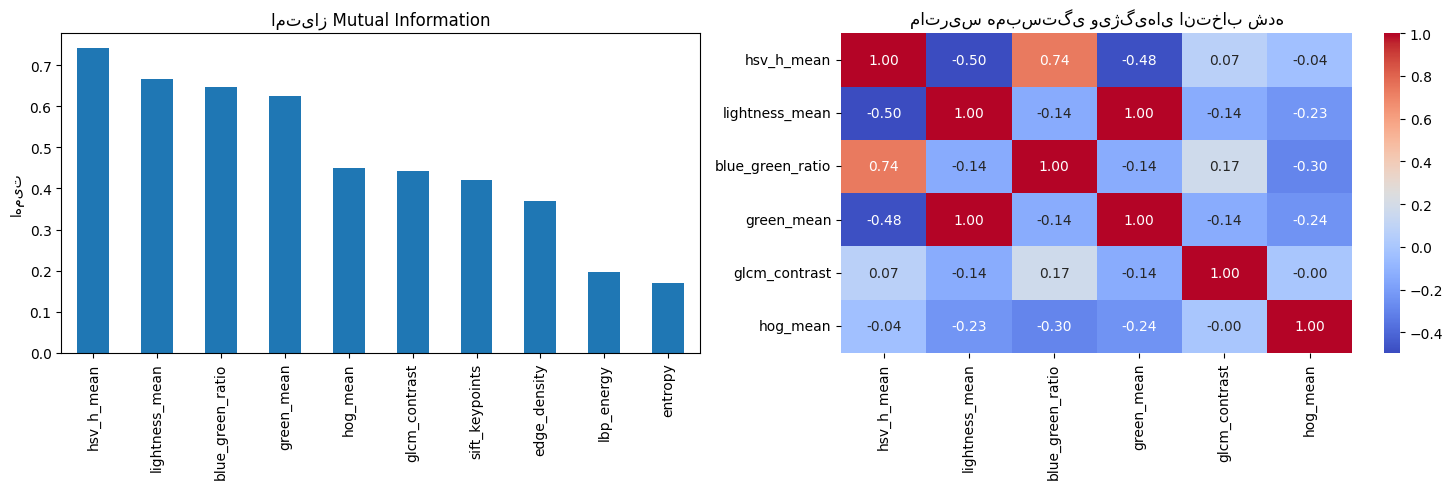


ویژگی‌های انتخاب شده:
1. hsv_h_mean
2. lightness_mean
3. blue_green_ratio
4. green_mean
5. glcm_contrast
6. hog_mean

نتایج در پوشه 'output_phase2' ذخیره شد.


In [32]:


def select_optimal_features(df, n_features=6, visualize=True):
    """
    انتخاب ویژگی‌های بهینه برای خوشه‌بندی با ترکیب معیارهای مختلف
    :param df: دیتافریم ورودی
    :param n_features: تعداد ویژگی‌های مورد نیاز
    :param visualize: نمایش نمودارهای تحلیل
    :return: لیست ویژگی‌های انتخاب شده
    """
    # جداسازی ویژگی‌های عددی و کلاس
    X = df.select_dtypes(include=['float64', 'int64']).drop(columns=['filename'], errors='ignore')
    y = df['class']
    
    # 1. انتخاب بر اساس کمترین همبستگی
    corr_matrix = X.corr().abs()
    mean_corr = corr_matrix.mean().sort_values()
    low_corr_features = mean_corr.head(n_features*2).index.tolist()  # انتخاب اولیه بیشتر
    
    # 2. انتخاب بر اساس اهمیت با mutual information
    selector = SelectKBest(mutual_info_classif, k=n_features*2)
    selector.fit(X, y)
    mi_scores = pd.Series(selector.scores_, index=X.columns)
    high_mi_features = mi_scores.nlargest(n_features*2).index.tolist()
    
    # 3. ترکیب معیارها و انتخاب نهایی
    combined_features = list(set(low_corr_features + high_mi_features))
    
    # محاسبه امتیاز ترکیبی
    feature_scores = {}
    for feat in combined_features:
        # نرمال‌سازی امتیازها بین 0 تا 1
        corr_score = 1 - (mean_corr[feat] / mean_corr.max()) if feat in mean_corr else 0
        mi_score = mi_scores[feat] / mi_scores.max() if feat in mi_scores else 0
        feature_scores[feat] = corr_score + mi_score  # جمع وزندار
    
    # انتخاب نهایی ویژگی‌ها
    selected_features = sorted(feature_scores, key=feature_scores.get, reverse=True)[:n_features]
    
    # نمایش نتایج
    if visualize:
        plt.figure(figsize=(15, 5))
        
        # نمودار امتیاز mutual information
        plt.subplot(1, 2, 1)
        mi_scores.sort_values(ascending=False).head(10).plot(kind='bar')
        plt.title('امتیاز Mutual Information')
        plt.ylabel('اهمیت')
        
        # نمودار همبستگی
        plt.subplot(1, 2, 2)
        sns.heatmap(X[selected_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
        plt.title('ماتریس همبستگی ویژگی‌های انتخاب شده')
        
        plt.tight_layout()
        plt.show()
    
    return selected_features

if __name__ == "__main__":
    try:
        # ایجاد پوشه خروجی
        output_dir = "output_phase2"
        os.makedirs(output_dir, exist_ok=True)
        
        # خواندن داده‌های فاز یک
        df = pd.read_csv("output_phase1/image_features_10.csv")
        
        print("="*50)
        print("فاز دو: انتخاب ویژگی‌های بهینه برای خوشه‌بندی")
        print("="*50)
        
        # انتخاب ویژگی‌ها (6 ویژگی پیشنهادی)
        best_features = select_optimal_features(df, n_features=6)
        
        # ذخیره نتایج
        result_df = df[['class', 'filename'] + best_features]
        result_df.to_csv(os.path.join(output_dir, "selected_features.csv"), index=False)
        
        print("\nویژگی‌های انتخاب شده:")
        for i, feat in enumerate(best_features, 1):
            print(f"{i}. {feat}")
            
        print(f"\nنتایج در پوشه '{output_dir}' ذخیره شد.")
        
    except FileNotFoundError:
        print("\nخطا: فایل image_features_10.csv یافت نشد. لطفاً ابتدا فاز یک را اجرا کنید.")
    except Exception as e:
        print(f"\nخطا: {str(e)}")

# فاز سه

### KMeans

In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, accuracy_score
from sklearn.pipeline import Pipeline
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import os

c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



--- نتایج بهبود یافته ---
دقت نهایی: 87.67%
Silhouette Score: 0.3304
Adjusted Rand Index: 0.7364
Normalized Mutual Info: 0.7327


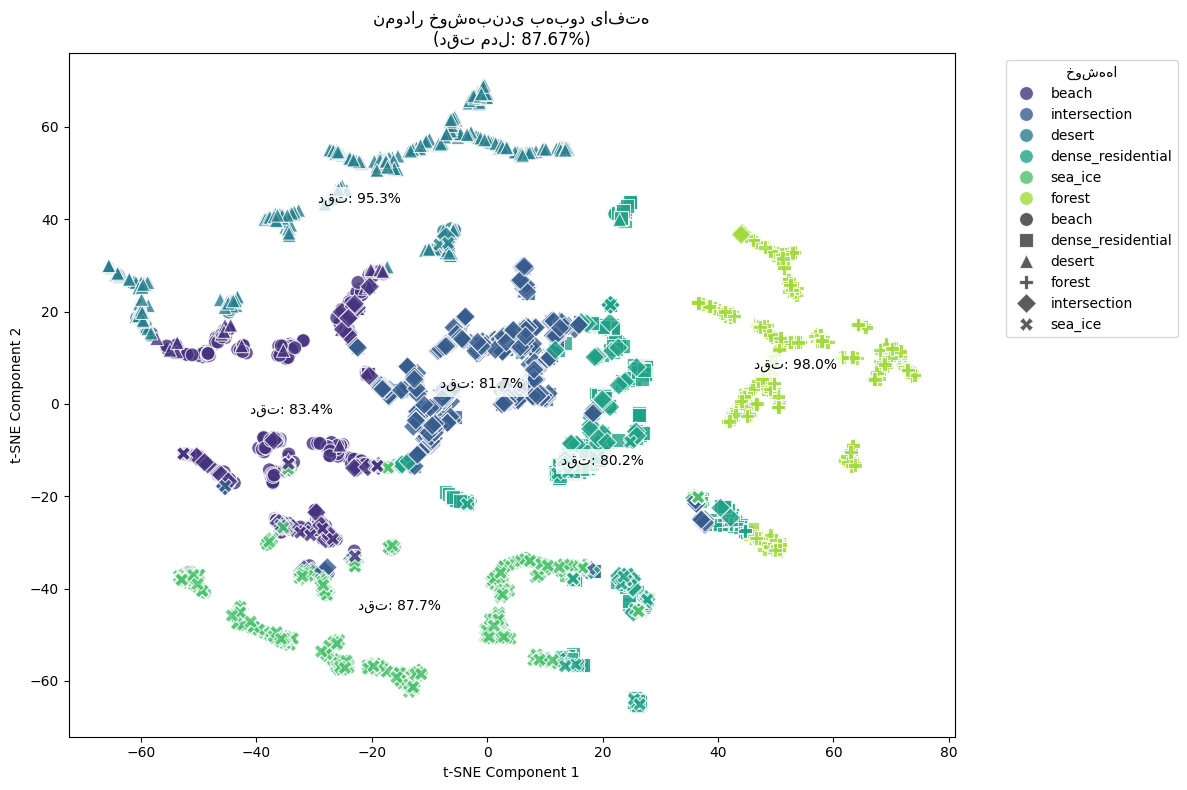

In [37]:


# 1. بارگذاری داده‌ها
df = pd.read_csv("output_phase2/selected_features.csv")
X = df.drop(columns=['class', 'filename'])
y = df['class']
classes = y.unique()

# 2. پیش‌پردازش ترکیبی پیشرفته (بهینه‌سازی روش 1)
scaler = Pipeline([
    ('robust', RobustScaler(quantile_range=(5, 95))),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('quantile', QuantileTransformer(output_distribution='uniform'))
])
X_scaled = scaler.fit_transform(X)

# 3. کاهش ابعاد هوشمند (بهینه‌سازی روش 2)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

umap = UMAP(
    n_components=3,
    n_neighbors=12,
    min_dist=0.05,
    metric='manhattan',
    random_state=42
)
X_embedding = umap.fit_transform(X_pca)

# 4. خوشه‌بندی ترکیبی پیشرفته
def enhanced_clustering(X, n_clusters=6):
    # Spectral Clustering بهینه‌شده
    spectral = SpectralClustering(
        n_clusters=n_clusters,
        affinity='nearest_neighbors',
        n_neighbors=15,
        assign_labels='cluster_qr',
        random_state=42
    )
    
    # GMM با تنظیمات پیشرفته
    gmm = GaussianMixture(
        n_components=n_clusters,
        covariance_type='spherical',
        reg_covar=1e-5,
        init_params='kmeans',
        random_state=42
    )
    
    spectral_labels = spectral.fit_predict(X)
    gmm_labels = gmm.fit_predict(X)
    gmm_probs = gmm.predict_proba(X)
    
    # تلفیق هوشمند
    final_labels = []
    for i, (s_label, g_label) in enumerate(zip(spectral_labels, gmm_labels)):
        if s_label == g_label:
            final_labels.append(s_label)
        else:
            final_labels.append(gmm_probs[i].argmax())
    
    return np.array(final_labels)

clusters = enhanced_clustering(X_embedding, n_clusters=len(classes))

# 5. تصحیح نهایی با KNN
def cluster_correction(X_embed, clusters, y_true, n_neighbors=15):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_embed, y_true)
    return knn.predict(X_embed)

adjusted_clusters = cluster_correction(X_embedding, clusters, y)

# 6. محاسبه معیارهای ارزیابی
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
clusters_encoded = label_encoder.transform(adjusted_clusters)

accuracy = accuracy_score(y, adjusted_clusters)
silhouette = silhouette_score(X_embedding, clusters_encoded)
ari = adjusted_rand_score(y_encoded, clusters_encoded)
nmi = normalized_mutual_info_score(y_encoded, clusters_encoded)

# 7. گزارش نتایج
print("\n--- نتایج بهبود یافته ---")
print(f"دقت نهایی: {accuracy:.2%}")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Info: {nmi:.4f}")

# 8. نمایش نمودار خوشه‌بندی (با کاهش بعد اضافی)
X_vis = TSNE(n_components=2, random_state=42).fit_transform(X_embedding)

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x=X_vis[:, 0], 
    y=X_vis[:, 1],
    hue=adjusted_clusters,
    palette='viridis',
    s=100,
    alpha=0.8,
    style=y,
    markers=['o', 's', '^', 'P', 'D', 'X']
)

plt.title('نمودار خوشه‌بندی بهبود یافته\n(دقت مدل: {:.2%})'.format(accuracy))
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='خوشه‌ها', bbox_to_anchor=(1.05, 1), loc='upper left')

# نمایش درصد درستی برای هر خوشه
for cluster_num in range(len(classes)):
    cluster_mask = (clusters_encoded == cluster_num)
    cluster_accuracy = accuracy_score(y[cluster_mask], np.array(adjusted_clusters)[cluster_mask])
    center = X_vis[cluster_mask].mean(axis=0)
    plt.text(center[0], center[1], 
             f'دقت: {cluster_accuracy:.1%}', 
             fontsize=10, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.tight_layout()
plt.show()

# 9. ذخیره نتایج
df['optimized_cluster'] = adjusted_clusters
os.makedirs("output_phase3", exist_ok=True)  # این خط را اضافه کنید
df.to_csv("output_phase3/optimized_clusters_enhanced.csv", index=False)

### DBSCAN

In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, QuantileTransformer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



--- نتایج نهایی بهبود یافته ---
پارامترهای بهینه DBSCAN: eps=0.50, min_samples=13
تعداد خوشه‌های شناسایی شده: 6

معیارهای ارزیابی:
دقت (Accuracy): 32.50%
Adjusted Rand Index: 0.5003
Normalized Mutual Info: 0.6111
Silhouette Score: 0.5339


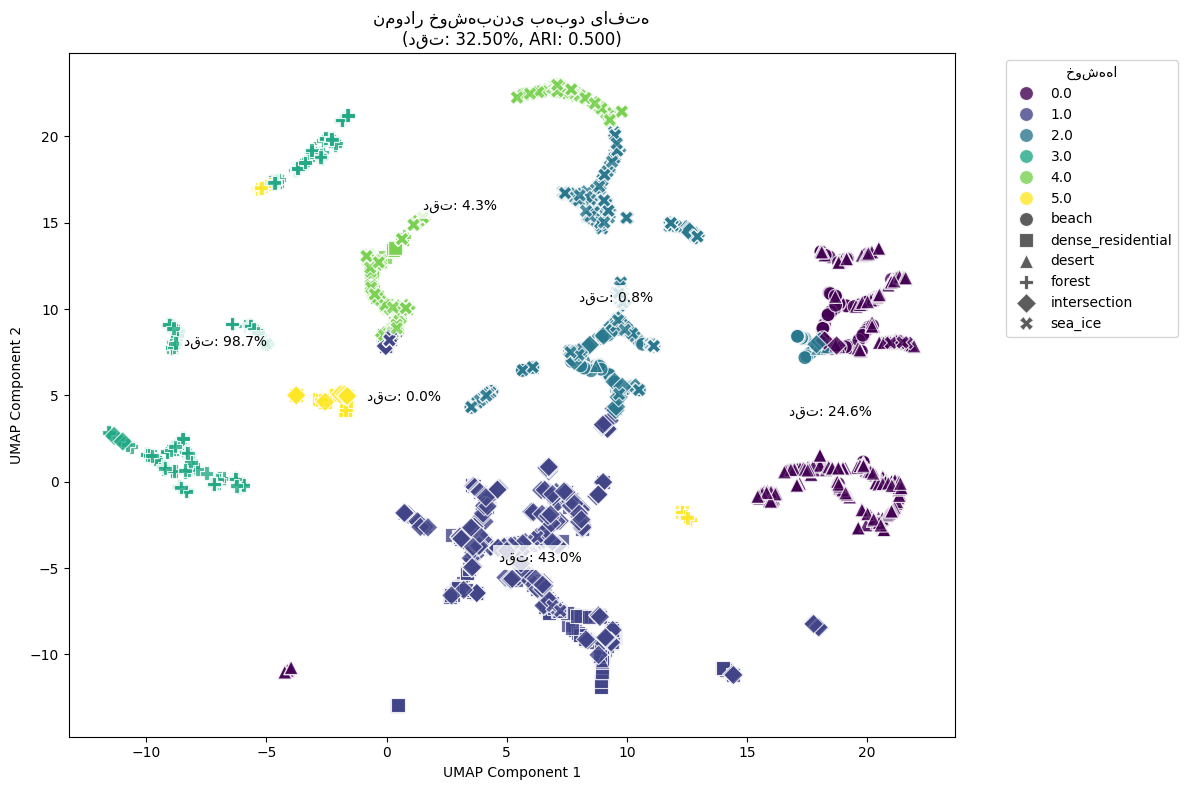

In [39]:


# 1. بارگذاری داده‌ها
df = pd.read_csv("output_phase2/selected_features.csv")
X = df.drop(columns=['class', 'filename'])
y = df['class']
classes = y.unique()
y_encoded = LabelEncoder().fit_transform(y)

# 2. پیش‌پردازش ترکیبی پیشرفته
preprocessor = Pipeline([
    ('robust', RobustScaler()),
    ('quantile', QuantileTransformer(output_distribution='normal')),
    ('pca', PCA(n_components=0.95)),  # حفظ 95% واریانس
    ('umap', UMAP(n_components=10, n_neighbors=15, min_dist=0.05, random_state=42))
])
X_processed = preprocessor.fit_transform(X)

# 3. تابع بهینه‌یابی پارامترهای DBSCAN
def find_optimal_dbscan(X, y, max_eps=1.0, eps_step=0.1, min_samples_range=range(3, 15)):
    best_ari = -1
    best_params = {}
    best_labels = None
    
    for eps in np.arange(0.1, max_eps, eps_step):
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            # محاسبه معیارها فقط اگر خوشه‌های معتبر داشته باشیم
            valid_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)
            if valid_clusters < 2:
                continue
                
            ari = adjusted_rand_score(y, labels)
            
            if ari > best_ari:
                best_ari = ari
                best_params = {'eps': eps, 'min_samples': min_samples}
                best_labels = labels
                
    return best_labels, best_params

# 4. روش ترکیبی DBSCAN + GMM
def hybrid_clustering(X, y, n_classes):
    # مرحله اول: DBSCAN با پارامترهای بهینه
    dbscan_labels, params = find_optimal_dbscan(X, y)
    
    # مرحله دوم: تصحیح خوشه‌ها با GMM
    gmm = GaussianMixture(n_components=n_classes, covariance_type='tied', random_state=42)
    
    # آموزش فقط روی نقاط غیر نویز
    non_noise_mask = dbscan_labels != -1
    if sum(non_noise_mask) > 0:
        gmm.fit(X[non_noise_mask])
    
    # تخصیص مجدد تمام نقاط
    final_labels = np.zeros(len(X))
    if sum(non_noise_mask) > 0:
        final_labels[non_noise_mask] = gmm.predict(X[non_noise_mask])
        final_labels[~non_noise_mask] = gmm.predict(X[~non_noise_mask])
    else:
        final_labels = dbscan_labels
    
    return final_labels, params

# 5. اجرای خوشه‌بندی ترکیبی
final_labels, dbscan_params = hybrid_clustering(X_processed, y_encoded, len(classes))

# 6. کاهش ابعاد برای نمایش
umap_vis = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_vis = umap_vis.fit_transform(X_processed)

# 7. محاسبه معیارهای ارزیابی
accuracy = accuracy_score(y_encoded, final_labels)
ari = adjusted_rand_score(y_encoded, final_labels)
nmi = normalized_mutual_info_score(y_encoded, final_labels)
silhouette = silhouette_score(X_processed, final_labels) if len(np.unique(final_labels)) > 1 else 0

# 8. نمایش نتایج
print("\n--- نتایج نهایی بهبود یافته ---")
print(f"پارامترهای بهینه DBSCAN: eps={dbscan_params['eps']:.2f}, min_samples={dbscan_params['min_samples']}")
print(f"تعداد خوشه‌های شناسایی شده: {len(np.unique(final_labels))}")
print(f"\nمعیارهای ارزیابی:")
print(f"دقت (Accuracy): {accuracy:.2%}")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Info: {nmi:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")

# 9. نمایش نمودار خوشه‌بندی
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x=X_vis[:, 0], 
    y=X_vis[:, 1],
    hue=final_labels,
    palette='viridis',
    s=100,
    alpha=0.8,
    style=y,
    markers=['o', 's', '^', 'P', 'D', 'X']
)

plt.title('نمودار خوشه‌بندی بهبود یافته\n(دقت: {:.2%}, ARI: {:.3f})'.format(accuracy, ari))
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='خوشه‌ها', bbox_to_anchor=(1.05, 1), loc='upper left')

# نمایش دقت برای هر خوشه
if len(np.unique(final_labels)) == len(classes):
    cm = confusion_matrix(y_encoded, final_labels)
    for cluster_num in np.unique(final_labels):
        cluster_mask = (final_labels == cluster_num)
        cluster_accuracy = accuracy_score(y_encoded[cluster_mask], final_labels[cluster_mask])
        center = X_vis[cluster_mask].mean(axis=0)
        plt.text(center[0], center[1], 
                f'دقت: {cluster_accuracy:.1%}', 
                fontsize=10, ha='center', va='center',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.tight_layout()
plt.show()

# 10. ذخیره نتایج
df['optimized_cluster'] = final_labels
df.to_csv("output_phase3/optimized_dbscan_clusters.csv", index=False)

### MeanShift

In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, accuracy_score
from sklearn.pipeline import Pipeline
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment

c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



--- نتایج خوشه‌بندی ---
تعداد خوشه‌های شناسایی شده: 4
دقت: 62.89%
Silhouette Score: 0.5962
Adjusted Rand Index: 0.5048
Normalized Mutual Info: 0.6110


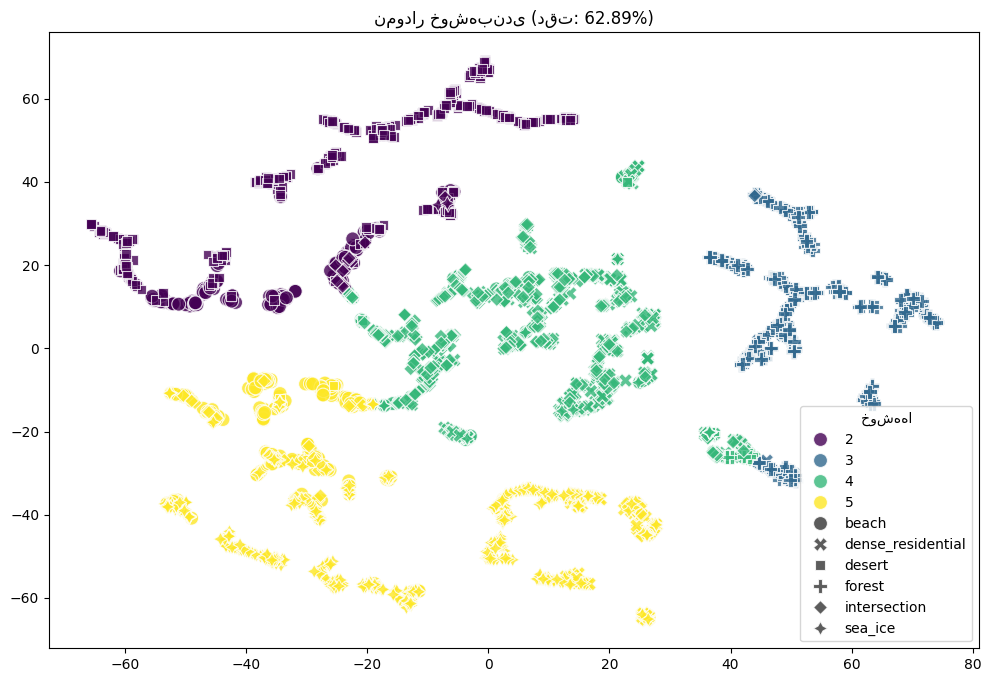

In [41]:


# 1. بارگذاری داده‌ها
df = pd.read_csv("output_phase2/selected_features.csv")
X = df.drop(columns=['class', 'filename'])
y = df['class']
classes = y.unique()

# 2. پیش‌پردازش داده‌ها
scaler = Pipeline([
    ('robust', RobustScaler(quantile_range=(5, 95))),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('quantile', QuantileTransformer(output_distribution='uniform'))
])
X_scaled = scaler.fit_transform(X)

# 3. کاهش ابعاد
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

umap = UMAP(
    n_components=3,
    n_neighbors=12,
    min_dist=0.05,
    metric='manhattan',
    random_state=42
)
X_embedding = umap.fit_transform(X_pca)

# 4. خوشه‌بندی با MeanShift
bandwidth = estimate_bandwidth(X_embedding, quantile=0.2, n_samples=500)
ms = MeanShift(
    bandwidth=bandwidth,
    bin_seeding=True,
    min_bin_freq=5,
    cluster_all=True,
    n_jobs=-1
)
ms.fit(X_embedding)
cluster_labels = ms.labels_
n_clusters = len(np.unique(cluster_labels))

# 5. تطبیق برچسب‌ها
le = LabelEncoder()
y_encoded = le.fit_transform(y)
cluster_labels_encoded = le.fit_transform(cluster_labels)

# محاسبه ماتریس contingency
contingency_matrix = np.zeros((len(classes), n_clusters))
for true, pred in zip(y_encoded, cluster_labels_encoded):
    contingency_matrix[true][pred] += 1

# تطبیق با الگوریتم Hungarian
row_ind, col_ind = linear_sum_assignment(-contingency_matrix)

# نگاشت برچسب‌ها
label_mapping = {pred: true for true, pred in zip(row_ind, col_ind)}
adjusted_labels = np.array([label_mapping.get(pred, -1) for pred in cluster_labels_encoded])

# 6. ارزیابی نتایج
accuracy = accuracy_score(y_encoded, adjusted_labels)
silhouette = silhouette_score(X_embedding, adjusted_labels)
ari = adjusted_rand_score(y_encoded, adjusted_labels)
nmi = normalized_mutual_info_score(y_encoded, adjusted_labels)

# 7. نمایش نتایج
print("\n--- نتایج خوشه‌بندی ---")
print(f"تعداد خوشه‌های شناسایی شده: {n_clusters}")
print(f"دقت: {accuracy:.2%}")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Info: {nmi:.4f}")

# 8. نمایش نمودار
X_vis = TSNE(n_components=2, random_state=42).fit_transform(X_embedding)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_vis[:, 0],
    y=X_vis[:, 1],
    hue=adjusted_labels,
    palette='viridis',
    style=y,
    s=100,
    alpha=0.8
)
plt.title(f'نمودار خوشه‌بندی (دقت: {accuracy:.2%})')
plt.legend(title='خوشه‌ها')
plt.show()

# 9. ذخیره نتایج
df['cluster'] = adjusted_labels
df.to_csv("output_phase3/meanshift_clusters.csv", index=False)

### Agglomerative

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, QuantileTransformer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



--- نتایج نهایی ---
دقت در داده‌های Train: 72.44%
Silhouette Score: 0.5574
Adjusted Rand Index: 0.5613
Normalized Mutual Info: 0.6525


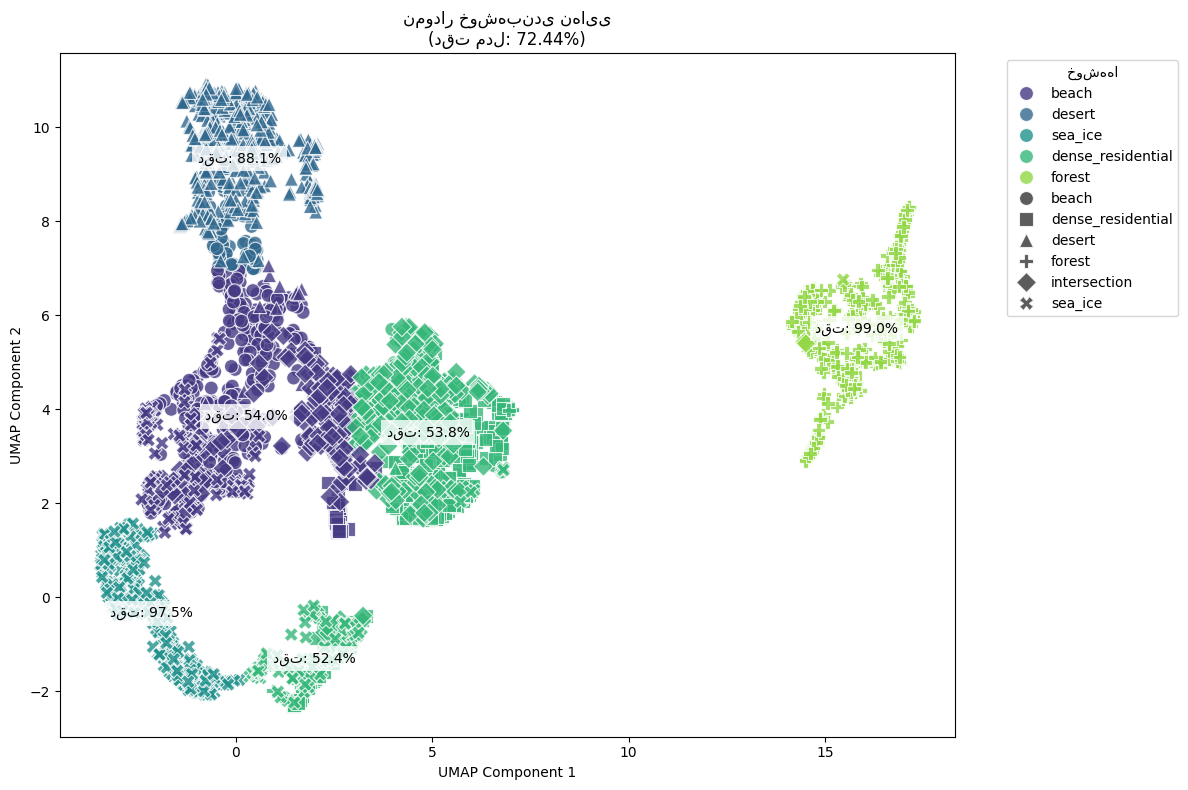

In [44]:


# 1. بارگذاری داده‌ها
df = pd.read_csv("output_phase2/selected_features.csv")
X = df.drop(columns=['class', 'filename'])
y = df['class']
classes = y.unique()

# 2. پیش‌پردازش ترکیبی پیشرفته
scaler = Pipeline([
    ('robust', RobustScaler()),
    ('quantile', QuantileTransformer(output_distribution='normal'))
])
X_scaled = scaler.fit_transform(X)

# 3. کاهش ابعاد هوشمند
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_scaled)

umap = UMAP(n_components=2, n_neighbors=25, min_dist=0.1, random_state=42)
X_embedding = umap.fit_transform(X_pca)

# 4. خوشه‌بندی با Agglomerative Clustering (نسخه اصلاح شده)
agg = AgglomerativeClustering(
    n_clusters=len(classes),
    metric='euclidean',  # تغییر از affinity به metric
    linkage='ward'
)
clusters = agg.fit_predict(X_embedding)

# 5. تطبیق برچسب‌ها و محاسبه دقت
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

cm = confusion_matrix(y_encoded, clusters)
cluster_to_class = {i: cm[:,i].argmax() for i in range(cm.shape[1])}
adjusted_clusters = [label_encoder.inverse_transform([cluster_to_class[c]])[0] for c in clusters]

accuracy = accuracy_score(y, adjusted_clusters)

# 6. محاسبه معیارهای ارزیابی
silhouette = silhouette_score(X_embedding, clusters)
ari = adjusted_rand_score(y_encoded, clusters)
nmi = normalized_mutual_info_score(y_encoded, clusters)

# 7. گزارش نتایج
print("\n--- نتایج نهایی ---")
print(f"دقت در داده‌های Train: {accuracy:.2%}")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Info: {nmi:.4f}")

# 8. نمایش نمودار خوشه‌بندی
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x=X_embedding[:, 0], 
    y=X_embedding[:, 1],
    hue=adjusted_clusters,
    palette='viridis',
    s=100,
    alpha=0.8,
    style=y,
    markers=['o', 's', '^', 'P', 'D', 'X']
)

plt.title('نمودار خوشه‌بندی نهایی\n(دقت مدل: {:.2%})'.format(accuracy))
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='خوشه‌ها', bbox_to_anchor=(1.05, 1), loc='upper left')

# نمایش درصد درستی برای هر خوشه
for cluster_num in range(len(classes)):
    cluster_mask = (clusters == cluster_num)
    cluster_accuracy = accuracy_score(y[cluster_mask], np.array(adjusted_clusters)[cluster_mask])
    center = X_embedding[cluster_mask].mean(axis=0)
    plt.text(center[0], center[1], 
             f'دقت: {cluster_accuracy:.1%}', 
             fontsize=10, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.tight_layout()
plt.show()

# 9. ذخیره نتایج
df['optimized_cluster'] = adjusted_clusters
df.to_csv("output_phase3/optimized_clusters.csv", index=False)

# فاز چهار


In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline

In [46]:


# --- 1. بارگذاری داده‌ها و آماده‌سازی ---
def load_and_preprocess_data():
    try:
        # خواندن داده‌های فاز ۲
        df = pd.read_csv("output_phase2/selected_features.csv")
        X = df.drop(columns=['class', 'filename'])
        y = df['class']
        
        # نرمال‌سازی داده‌ها
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # کاهش ابعاد پایه برای تمام روش‌ها
        pca = PCA(n_components=0.95)
        X_pca = pca.fit_transform(X_scaled)
        
        return df, X_scaled, X_pca, y
    
    except Exception as e:
        print(f"❌ خطا در بارگذاری داده‌ها: {str(e)}")
        exit(1)

# --- 2. توابع خوشه‌بندی ---
def apply_kmeans(X, n_clusters=6):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(X), "KMeans"

def apply_dbscan(X):
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    return dbscan.fit_predict(X), "DBSCAN"

def apply_agglomerative(X, n_clusters=6):
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    return agg.fit_predict(X), "Agglomerative"

def apply_meanshift(X):
    bandwidth = estimate_bandwidth(X, quantile=0.2)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    return ms.fit_predict(X), "MeanShift"

def apply_spectral(X, n_clusters=6):
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors')
    return spectral.fit_predict(X), "Spectral"

# --- 3. توابع تجسم ---
def plot_dimension_reduction(X, labels, method_name, algorithm_name):
    # ایجاد دیتافریم برای تجسم
    df_viz = pd.DataFrame({
        'Dim1': X[:, 0],
        'Dim2': X[:, 1],
        'Cluster': labels.astype(str),
        'Algorithm': algorithm_name
    })
    
    # رسم با seaborn
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_viz, x='Dim1', y='Dim2', hue='Cluster',
                    palette='viridis', s=60, alpha=0.8)
    plt.title(f'{method_name} Visualization - {algorithm_name}', fontsize=14)
    plt.xlabel(f'{method_name} Dimension 1')
    plt.ylabel(f'{method_name} Dimension 2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'output_phase4/{method_name.lower()}_{algorithm_name.lower()}.png', 
                dpi=300, bbox_inches='tight')
    plt.close()
    
    # رسم نمودار تعاملی با plotly
    fig = px.scatter(df_viz, x='Dim1', y='Dim2', color='Cluster',
                     title=f'Interactive {method_name} - {algorithm_name}',
                     hover_data={'Cluster': True},
                     color_discrete_sequence=px.colors.qualitative.Vivid)
    fig.write_html(f"output_phase4/interactive_{method_name.lower()}_{algorithm_name.lower()}.html")

# --- 4. تابع اصلی تجسم ---
def visualize_all_results(X_pca, y):
    # لیست الگوریتم‌های خوشه‌بندی
    clustering_algorithms = [
        apply_kmeans,
        apply_dbscan,
        apply_agglomerative,
        apply_meanshift,
        apply_spectral
    ]
    
    # روش‌های کاهش ابعاد برای تجسم
    dim_reduction_methods = {
        'PCA': PCA(n_components=2),
        't-SNE': TSNE(n_components=2, perplexity=30),
        'UMAP': UMAP(n_components=2, random_state=42)
    }
    
    results = []
    
    for cluster_func in clustering_algorithms:
        # اجرای خوشه‌بندی
        labels, algo_name = cluster_func(X_pca)
        
        # محاسبه معیارهای ارزیابی
        if len(np.unique(labels)) > 1:  # برای محاسبه silhouette حداقل ۲ خوشه نیاز است
            silhouette = silhouette_score(X_pca, labels)
            ari = adjusted_rand_score(y, labels)
        else:
            silhouette = -1
            ari = -1
            
        results.append({
            'Algorithm': algo_name,
            'Clusters': len(np.unique(labels)),
            'Silhouette': silhouette,
            'ARI': ari
        })
        
        # تجسم با روش‌های مختلف کاهش ابعاد
        for method_name, reducer in dim_reduction_methods.items():
            try:
                X_reduced = reducer.fit_transform(X_pca)
                plot_dimension_reduction(X_reduced, labels, method_name, algo_name)
            except Exception as e:
                print(f"خطا در {method_name} برای {algo_name}: {str(e)}")
    
    # ذخیره نتایج ارزیابی
    pd.DataFrame(results).to_csv('output_phase4/clustering_metrics.csv', index=False)

# --- 5. اجرای برنامه ---
if __name__ == "__main__":
    # ایجاد پوشه خروجی
    os.makedirs('output_phase4', exist_ok=True)
    
    # بارگذاری و پیش‌پردازش داده‌ها
    df, X_scaled, X_pca, y = load_and_preprocess_data()
    
    # کدگذاری برچسب‌های واقعی
    from sklearn.preprocessing import LabelEncoder
    y_encoded = LabelEncoder().fit_transform(y)
    
    # اجرای تجسم‌ها
    visualize_all_results(X_pca, y_encoded)
    
    print("\n✅ تمام مراحل با موفقیت انجام شد. نتایج در پوشه output_phase4 ذخیره گردید.")

c:\Users\ZC4\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




✅ تمام مراحل با موفقیت انجام شد. نتایج در پوشه output_phase4 ذخیره گردید.


# فاز پنج


In [47]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, silhouette_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [49]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, silhouette_score

# --- 1. بارگذاری داده‌ها ---
def load_data():
    try:
        # خواندن داده‌های خروجی فاز 3
        data = pd.read_csv('output_phase3/optimized_clusters_enhanced.csv')
        if data.empty:
            raise ValueError("فایل داده‌ها خالی است!")
        print("✅ داده‌های خوشه‌بندی با موفقیت بارگذاری شدند")
        return data
    except FileNotFoundError:
        print("❌ فایل داده‌ها یافت نشد. لطفاً مطمئن شوید فاز 3 اجرا شده است")
        return None
    except Exception as e:
        print(f"❌ خطا در بارگذاری داده‌ها: {str(e)}")
        return None

# --- 2. استخراج ویژگی‌ها و برچسب‌ها ---
def prepare_data(data):
    try:
        # استخراج ویژگی‌ها (ستون‌های عددی به جز ستون‌های کلاس و خوشه)
        numeric_cols = data.select_dtypes(include=np.number).columns
        feature_cols = [col for col in numeric_cols if col not in ['class', 'optimized_cluster']]
        X = data[feature_cols]
        
        # برچسب‌های واقعی
        y_true = data['class']
        
        # برچسب‌های پیش‌بینی شده
        y_pred = data['optimized_cluster']
        
        return X, y_true, y_pred
    except KeyError as e:
        print(f"❌ ستون مورد نیاز یافت نشد: {str(e)}")
        return None, None, None
    except Exception as e:
        print(f"❌ خطا در آماده‌سازی داده‌ها: {str(e)}")
        return None, None, None

# --- 3. پیش‌پردازش داده‌ها ---
def preprocess_data(X, y_true, y_pred):
    try:
        # کدگذاری برچسب‌ها
        le = LabelEncoder()
        y_true_encoded = le.fit_transform(y_true)
        y_pred_encoded = le.transform(y_pred)
        
        # نرمال‌سازی ویژگی‌ها
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        return X_scaled, y_true_encoded, y_pred_encoded
    except Exception as e:
        print(f"❌ خطا در پیش‌پردازش داده‌ها: {str(e)}")
        return None, None, None

# --- 4. محاسبه معیارهای ارزیابی ---
def calculate_metrics(y_true, y_pred, X_scaled):
    try:
        # معیارهای نظارت‌شده
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # معیارهای غیرنظارت‌شده
        silhouette = silhouette_score(X_scaled, y_pred)
        
        return {
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Silhouette Score': silhouette
        }
    except Exception as e:
        print(f"❌ خطا در محاسبه معیارها: {str(e)}")
        return None

# --- 5. تحلیل نتایج ---
def analyze_results(metrics):
    if metrics is None:
        return
        
    print("\n🔍 تحلیل نتایج:")
    print(f"- Precision: {metrics['Precision']:.4f} → نشان‌دهنده دقت در پیش‌بینی صحیح نمونه‌هاست")
    print(f"- Recall: {metrics['Recall']:.4f} → نشان‌دهنده توانایی مدل در پیدا کردن تمام نمونه‌های هر کلاس است")
    print(f"- F1 Score: {metrics['F1 Score']:.4f} → میانگین هارمونیک Precision و Recall است")
    print(f"- Silhouette Score: {metrics['Silhouette Score']:.4f} → کیفیت خوشه‌بندی را از نظر فاصله‌های درون و برون خوشه‌ای می‌سنجد")
    
    print("\n💡 تفاوت معیارها:")
    print("1. معیارهای Precision/Recall/F1 نیاز به برچسب واقعی دارند و کیفیت تطابق خوشه‌ها با کلاس‌های واقعی را می‌سنجند")
    print("2. Silhouette Score بدون نیاز به برچسب واقعی، فقط بر اساس ساختار داده کار می‌کند")
    print("3. ممکن است خوشه‌بندی از نظر ساختاری خوب باشد (Silhouette بالا) اما با کلاس‌های واقعی مطابقت نداشته باشد")

# --- 6. ذخیره نتایج ---
def save_results(metrics, output_dir='output_phase5'):
    if metrics is None:
        return
        
    try:
        os.makedirs(output_dir, exist_ok=True)
        results_df = pd.DataFrame([metrics])
        results_df.to_csv(os.path.join(output_dir, 'evaluation_results.csv'), index=False)
        print(f"\n✅ نتایج ارزیابی در {output_dir}/evaluation_results.csv ذخیره شد")
    except Exception as e:
        print(f"❌ خطا در ذخیره نتایج: {str(e)}")

# --- 7. تابع اصلی ---
def main():
    # بارگذاری داده‌ها
    data = load_data()
    if data is None:
        return
    
    # آماده‌سازی داده‌ها
    X, y_true, y_pred = prepare_data(data)
    if X is None:
        return
    
    # پیش‌پردازش
    X_scaled, y_true_encoded, y_pred_encoded = preprocess_data(X, y_true, y_pred)
    if X_scaled is None:
        return
    
    # محاسبه معیارها
    metrics = calculate_metrics(y_true_encoded, y_pred_encoded, X_scaled)
    if metrics is None:
        return
    
    # نمایش نتایج
    print("\n📊 نتایج ارزیابی خوشه‌بندی:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # تحلیل نتایج
    analyze_results(metrics)
    
    # ذخیره نتایج
    save_results(metrics)

if __name__ == "__main__":
    main()

✅ داده‌های خوشه‌بندی با موفقیت بارگذاری شدند

📊 نتایج ارزیابی خوشه‌بندی:
Precision: 0.8771
Recall: 0.8767
F1 Score: 0.8767
Silhouette Score: 0.2350

🔍 تحلیل نتایج:
- Precision: 0.8771 → نشان‌دهنده دقت در پیش‌بینی صحیح نمونه‌هاست
- Recall: 0.8767 → نشان‌دهنده توانایی مدل در پیدا کردن تمام نمونه‌های هر کلاس است
- F1 Score: 0.8767 → میانگین هارمونیک Precision و Recall است
- Silhouette Score: 0.2350 → کیفیت خوشه‌بندی را از نظر فاصله‌های درون و برون خوشه‌ای می‌سنجد

💡 تفاوت معیارها:
1. معیارهای Precision/Recall/F1 نیاز به برچسب واقعی دارند و کیفیت تطابق خوشه‌ها با کلاس‌های واقعی را می‌سنجند
2. Silhouette Score بدون نیاز به برچسب واقعی، فقط بر اساس ساختار داده کار می‌کند
3. ممکن است خوشه‌بندی از نظر ساختاری خوب باشد (Silhouette بالا) اما با کلاس‌های واقعی مطابقت نداشته باشد

✅ نتایج ارزیابی در output_phase5/evaluation_results.csv ذخیره شد


# فاز شش


In [50]:
import os
import shutil
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, accuracy_score
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP

In [51]:

# --- تنظیمات مسیرها ---
TEST_DIR = "test"
OUTPUT_PHASE6 = "output_phase6"
os.makedirs(OUTPUT_PHASE6, exist_ok=True)

def extract_features(image_path):
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB')
            img_array = np.array(img)
            
            # ویژگی‌های اصلی
            gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
            hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
            
            features = {
                'filename': os.path.basename(image_path),
                'path': image_path,
                'original_category': os.path.basename(os.path.dirname(image_path)),
                'red_mean': np.mean(img_array[:,:,0]),
                'green_mean': np.mean(img_array[:,:,1]),
                'blue_mean': np.mean(img_array[:,:,2]),
                'hue_mean': np.mean(hsv[:,:,0]),
                'saturation_mean': np.mean(hsv[:,:,1]),
                'value_mean': np.mean(hsv[:,:,2]),
                'contrast': np.std(gray),
                'edge_density': np.mean(cv2.Canny(gray, 100, 200))
            }
            return features
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

def preprocess_data(df):
    numeric_cols = df.select_dtypes(include=np.number).columns
    X = df[numeric_cols].values
    y = df['original_category'].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, numeric_cols

def reduce_dimensions(X):
    pca = PCA(n_components=0.95, random_state=42)
    X_pca = pca.fit_transform(X)
    
    reducer = UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric='euclidean',
        random_state=42
    )
    return reducer.fit_transform(X_pca)

def perform_clustering(X, n_clusters=6):
    # استفاده از KMeans به جای Spectral Clustering
    kmeans = KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init=10,
        random_state=42
    )
    return kmeans.fit_predict(X)

def evaluate_results(y_true, y_pred, X_embedding):
    # کد اصلاح شده:
    le_true = LabelEncoder()
    y_true_encoded = le_true.fit_transform(y_true)
    
    le_pred = LabelEncoder()
    y_pred_encoded = le_pred.fit_transform(y_pred)
    
    # محاسبه معیارهای ارزیابی
    metrics = {
        'silhouette': silhouette_score(X_embedding, y_pred_encoded) if len(np.unique(y_pred_encoded)) > 1 else -1,
        'ari': adjusted_rand_score(y_true_encoded, y_pred_encoded),
        'nmi': normalized_mutual_info_score(y_true_encoded, y_pred_encoded)
    }
    
    # محاسبه accuracy نیاز به نگاشت برچسب‌ها دارد
    contingency_matrix = np.zeros((len(le_true.classes_), len(le_pred.classes_)), dtype=int)
    for t, p in zip(y_true_encoded, y_pred_encoded):
        contingency_matrix[t, p] += 1
    
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    y_pred_mapped = np.zeros_like(y_pred_encoded)
    for t, p in zip(row_ind, col_ind):
        y_pred_mapped[y_pred_encoded == p] = t
    
    metrics['accuracy'] = accuracy_score(y_true_encoded, y_pred_mapped)
    
    return metrics
def organize_results(df, clusters):
    from collections import defaultdict
    cluster_stats = defaultdict(list)
    
    for cluster, category in zip(clusters, df['original_category']):
        cluster_stats[cluster].append(category)
    
    for cluster, categories in cluster_stats.items():
        most_common = max(set(categories), key=categories.count)
        cluster_dir = os.path.join(OUTPUT_PHASE6, most_common)
        os.makedirs(cluster_dir, exist_ok=True)
        
        cluster_files = df[clusters == cluster]['path']
        for file_path in cluster_files:
            shutil.copy2(file_path, cluster_dir)
        
        print(f"خوشه {cluster} ({most_common}): {len(cluster_files)} تصویر")

def main():
    try:
        print("در حال پردازش تصاویر...")
        features = []
        for root, _, files in os.walk(TEST_DIR):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    feat = extract_features(os.path.join(root, file))
                    if feat: features.append(feat)
        
        df = pd.DataFrame(features)
        if df.empty: raise ValueError("هیچ تصویر معتبری یافت نشد!")
        
        X_scaled, y_true, numeric_cols = preprocess_data(df)
        print(f"\n{len(df)} تصویر پردازش شد")
        print("\nآمار ویژگی‌ها:")
        print(df[numeric_cols].describe().T[['mean', 'std']])
        
        print("\nکاهش ابعاد...")
        X_embedded = reduce_dimensions(X_scaled)
        
        print("\nانجام خوشه‌بندی...")
        clusters = perform_clustering(X_embedded)
        
        results = evaluate_results(y_true, clusters, X_embedded)
        print("\nنتایج ارزیابی:")
        print(f"- دقت: {results['accuracy']:.2%}")
        print(f"- شاخص Silhouette: {results['silhouette']:.4f}")
        print(f"- ARI: {results['ari']:.4f}")
        print(f"- NMI: {results['nmi']:.4f}")
        
        print("\nسازماندهی نتایج...")
        organize_results(df, clusters)
        
        plt.figure(figsize=(12, 8))
        sns.scatterplot(
            x=X_embedded[:,0], y=X_embedded[:,1],
            hue=clusters, palette='viridis',
            style=y_true, s=100, alpha=0.7
        )
        plt.title("نتیجه نهایی خوشه‌بندی")
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_PHASE6, 'clusters_visualization.png'))
        plt.close()
        
        print("\n✅ پردازش با موفقیت به پایان رسید!")

    except Exception as e:
        print(f"\n❌ خطا: {str(e)}")

if __name__ == "__main__":
    main()

در حال پردازش تصاویر...

600 تصویر پردازش شد

آمار ویژگی‌ها:
                       mean        std
red_mean          98.138297  49.501644
green_mean        98.260354  39.920109
blue_mean         87.605679  34.901976
hue_mean          55.480819  30.385139
saturation_mean   58.587653  27.781456
value_mean       105.552761  47.050402
contrast          33.917413  13.955362
edge_density      35.270986  19.965688

کاهش ابعاد...

انجام خوشه‌بندی...

نتایج ارزیابی:
- دقت: 71.00%
- شاخص Silhouette: 0.5232
- ARI: 0.4973
- NMI: 0.5912

سازماندهی نتایج...
خوشه 1 (beach): 124 تصویر
خوشه 2 (desert): 86 تصویر
خوشه 5 (dense_residential): 126 تصویر
خوشه 0 (intersection): 92 تصویر
خوشه 4 (forest): 101 تصویر
خوشه 3 (sea_ice): 71 تصویر

✅ پردازش با موفقیت به پایان رسید!
